# 1. EDA

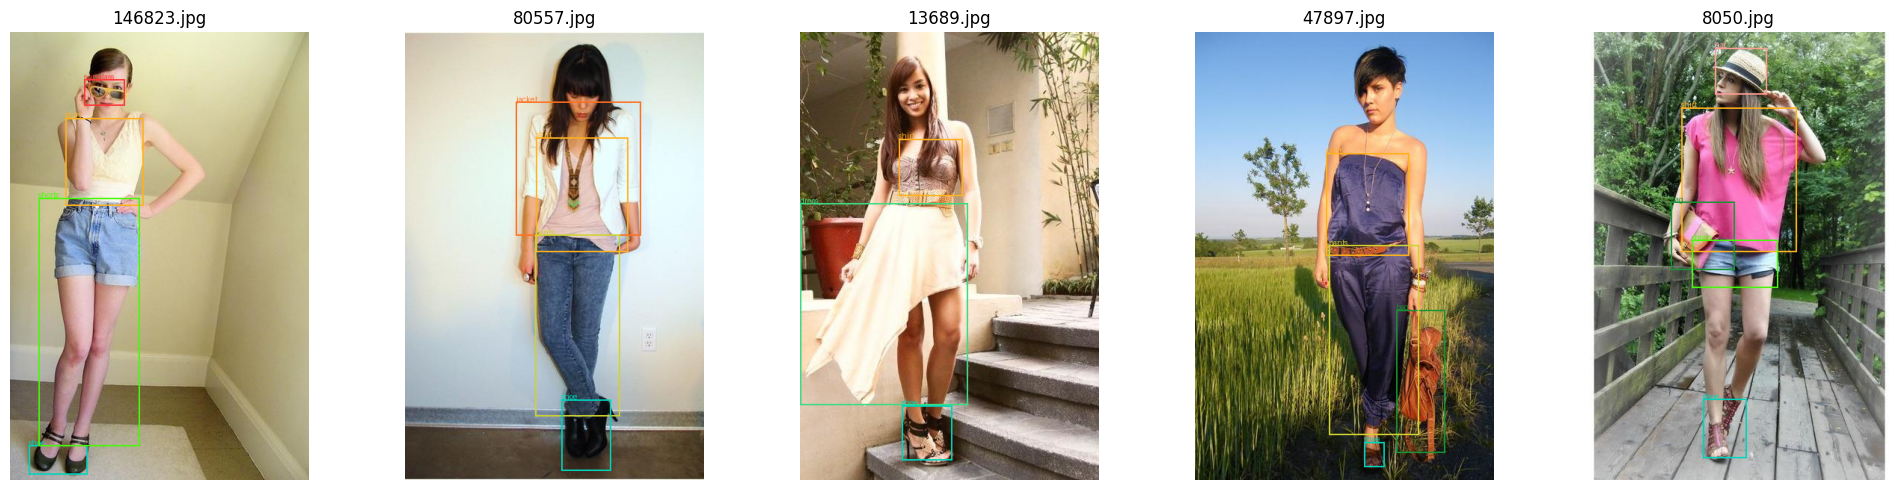

In [1]:
import os
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Definieer de paden naar de data
base_path = 'transforming-fashion-2025/Dataset'
image_dir = os.path.join(base_path, 'Train', 'images')
label_dir = os.path.join(base_path, 'Train', 'labels')

# Definieer de klassenamen zoals gespecificeerd in de opdracht 
class_names = {
    0: 'sunglass', 1: 'hat', 2: 'jacket', 3: 'shirt', 4: 'pants',
    5: 'shorts', 6: 'skirt', 7: 'dress', 8: 'bag', 9: 'shoe'
}

# Kleuren voor de bounding boxes per klasse
# We gebruiken een lijst met kleuren om elke klasse een unieke kleur te geven
colors = ['#FF3838', '#FF9D97', '#FF701F', '#FFB21D', '#CFD231', '#48F90A', '#92CC17', '#3DDB86', '#1A9334', '#00D4BB']

# Haal een lijst op van alle afbeeldingen en selecteer er 5 willekeurig
all_images = os.listdir(image_dir)
selected_images = random.sample(all_images, 5)

# Maak een plot om de afbeeldingen weer te geven
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, image_name in enumerate(selected_images):
    # Bouw de volledige paden naar de bestanden
    image_path = os.path.join(image_dir, image_name)
    
    # De naam van het labelbestand is gelijk aan de afbeeldingsnaam, maar met .txt extensie 
    label_name = os.path.splitext(image_name)[0] + '.txt'
    label_path = os.path.join(label_dir, label_name)

    # Laad de afbeelding
    img = Image.open(image_path).convert("RGB")
    draw = ImageDraw.Draw(img)
    img_width, img_height = img.size

    # Verwerk het labelbestand
    with open(label_path, 'r') as f:
        # Elke rij in het bestand is een object 
        for line in f.readlines():
            parts = line.strip().split()
            
            # Lees de data uit de regel
            class_id = int(parts[0])
            center_x_norm = float(parts[1])
            center_y_norm = float(parts[2])
            width_norm = float(parts[3])
            height_norm = float(parts[4])

            # De-normaliseer de coördinaten naar pixelwaarden 
            center_x = center_x_norm * img_width
            center_y = center_y_norm * img_height
            box_width = width_norm * img_width
            box_height = height_norm * img_height

            # Bereken de hoekpunten van de bounding box
            # (x_min, y_min) is de linkerbovenhoek, (x_max, y_max) de rechteronderhoek
            x_min = center_x - (box_width / 2)
            y_min = center_y - (box_height / 2)
            x_max = center_x + (box_width / 2)
            y_max = center_y + (box_height / 2)
            
            # Teken de bounding box
            draw.rectangle([x_min, y_min, x_max, y_max], outline=colors[class_id], width=2)
            
            # Voeg de klassenaam als label toe
            label_text = class_names[class_id]
            draw.text((x_min, y_min - 10), label_text, fill=colors[class_id])

    # Toon de afbeelding in de subplot
    axs[i].imshow(img)
    axs[i].set_title(image_name)
    axs[i].axis('off')

# Toon de volledige plot
plt.tight_layout()
plt.show()

# 2. Objectdetectie

## 2.1 Inleiding
Voor deze opdracht wordt YOLOv8 (You Only Look Once, versie 8) gebruikt. Dit is een
state-of-the-art, real-time objectdetectiemodel dat bekend staat om zijn snelheid en
hoge nauwkeurigheid. We gebruiken een voorgetraind model ('yolov8n.pt'), dat al
getraind is op de grote COCO-dataset. Door dit model te 'fine-tunen' op onze
fashion-dataset, kan het met relatief weinig trainingstijd leren om de specifieke
kledingstukken te herkennen.

## 2.2 Hoe het model voorspellingen doet
Het YOLOv8-model doet voorspellingen in één enkele pass door het neurale netwerk,
vandaar de naam 'You Only Look Once'. Het proces kan als volgt worden samengevat
(Jocher et al., 2023):
1. Input & Backbone: De input-afbeelding wordt eerst door een 'backbone'-netwerk
   (CSPDarknet53) gestuurd. Deze backbone extraheert op verschillende schalen
   'feature maps'. Dit zijn representaties van de afbeelding waarin belangrijke
   visuele kenmerken (zoals randen, texturen, vormen) zijn vastgelegd.
2. Neck: De feature maps van de backbone gaan vervolgens naar de 'neck'
   (een PANet-structuur). De neck combineert de feature maps van verschillende
   schalen. Dit helpt het model om zowel kleine als grote objecten goed te
   detecteren.
3. Head (Detectie): De 'head' van het model is verantwoordelijk voor de uiteindelijke
   voorspellingen. YOLOv8 is 'anchor-free'. In plaats van vooraf gedefinieerde
   'anchor boxes' te gebruiken, voorspelt de head direct het middelpunt, de
   hoogte en breedte van een object. Voor elke locatie in de feature map voorspelt
   de head:
   - Een class-score voor elk van de 10 klassen (shirt, tas, etc.).
   - De coördinaten en afmetingen van de bounding box.
4. Output: Na een non-maximum suppression (NMS) stap, die overlappende bounding
   boxes voor hetzelfde object wegfiltert, blijven de definitieve detecties over.

## 2.3 Hoe de afbeeldingen worden voorbewerkt (Preprocessing & Augmentation)
De `ultralytics` library handelt de voorbewerking en data-augmentatie automatisch
af tijdens de training. Dit is een cruciaal proces voor het behalen van goede
resultaten en het voorkomen van overfitting.

Voorbewerking:
- Resizing: Alle afbeeldingen worden naar een vaste grootte geschaald,
  gespecificeerd door de hyperparameter `imgsz` (in ons geval 640x640 pixels).
- Normalisatie: De pixelwaarden (0-255) worden genormaliseerd naar een schaal
  van 0.0 tot 1.0. Dit is een standaardprocedure die de training stabiliseert.

Data Augmentatie:
Tijdens de training worden willekeurige aanpassingen op de afbeeldingen toegepast.
Hierdoor 'ziet' het model elke afbeelding steeds in een iets andere vorm, wat helpt
om een robuuster model te trainen (Jocher et al., 2023). Standaard past YOLOv8 o.a.
de volgende augmentaties toe:
- Kleurruimte aanpassingen (Hue, Saturation, Value).
- Horizontaal spiegelen (`fliplr`).
- Schalen en transleren.

## 2.4 Feature Engineering
Bij het gebruik van diepe neurale netwerken zoals YOLOv8 is traditionele, handmatige
'feature engineering' niet van toepassing. De kracht van deep learning modellen ligt
juist in het feit dat ze hiërarchische features zelfstandig leren uit de data
(LeCun et al., 2015). De convolutionele lagen in de 'backbone' functioneren als
automatische feature extractors:
- De eerste lagen leren simpele features zoals randen en kleuren.
- Diepere lagen combineren deze om complexere patronen te herkennen, zoals
  stoffen, knopen, of de vorm van een broekspijp.
Onze taak is dus niet het ontwerpen van features, maar het correct aanleveren van
gelabelde data en het juist configureren van het trainingsproces.

## 2.5 Onderbouwing van Hyperparameters, Optimizer en Epochs 
De keuzes hieronder zijn een balans tussen prestaties en trainingstijd.
- `data`: 'data.yaml'. Dit is het configuratiebestand
  dat we eerder hebben gemaakt. Het vertelt het model waar de data staat en wat
  de klassen zijn.
- `epochs`: 100. Een epoch is één volledige doorgang over de gehele trainingsdataset.
  100 epochs is een solide startpunt. Door 'patience' te gebruiken, zal de
  training eerder stoppen als het model niet meer verbetert, wat overbodige
  trainingstijd voorkomt.
- `patience`: 20. Dit is voor 'early stopping'. Als de mAP@0.5 score (de primaire
  evaluatiemetriek) op de validatieset 20 epochs lang niet verbetert, wordt de
  training automatisch gestopt. Dit voorkomt overfitting en slaat het best
  presterende model op.
- `batch`: 16. Dit is het aantal afbeeldingen dat tegelijk door het netwerk wordt
  verwerkt. 16 is een gangbare waarde die vaak goed past op moderne GPU's. Een
  grotere batch size kan de training versnellen, maar vereist meer VRAM.
- `imgsz`: 640. De invoerafbeeldingen worden naar 640x640 pixels geschaald. Dit
  is een standaard en effectieve resolutie voor YOLO-modellen.
- `optimizer`: 'AdamW'. Hoewel de `ultralytics` library zelf de optimizer kiest
  (standaard 'AdamW'), is dit een uitstekende keuze. AdamW (Adaptive Moment
  Estimation with Weight Decay) is een variant van de populaire Adam-optimizer die
  'weight decay' op een effectievere manier toepast, wat vaak leidt tot betere
  generalisatie en dus een beter presterend model (Loshchilov & Hutter, 2019).

## 2.6 De Loss Functie 
De totale loss van het model is een som van drie componenten. De loss-functie
berekent het verschil tussen de voorspelling van het model en de ware labels, en
stuurt het leerproces door dit verschil te minimaliseren (Jocher et al., 2023).
1. Box Loss (Regressie Loss): Deze berekent de fout in de locatie en grootte van
   de voorspelde bounding box. YOLOv8 gebruikt 'Complete IoU' (CIoU) loss. Deze
   houdt niet alleen rekening met de overlap (Intersection over Union), maar ook
   met de afstand tussen de middelpunten en het verschil in beeldverhouding.
   Daarnaast wordt 'Distribution Focal Loss' (DFL) gebruikt om de continue
   locaties van de box te leren als een discrete distributie, wat de precisie
   verhoogt.
2. Class Loss (Classificatie Loss): Deze berekent hoe goed het model de juiste
   klasse voorspelt (bv. 'shirt' vs 'broek'). Hiervoor wordt 'Binary Cross-Entropy'
   (BCE) gebruikt. Deze meet de fout voor elke klasse afzonderlijk.
De gewogen som van deze losses vormt de uiteindelijke loss-waarde die het model
tijdens de training probeert te minimaliseren.

In [4]:
import torch
print(f"CUDA Available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    for device in range(torch.cuda.device_count()):
        print(f"CUDA Device Name {device + 1}: {torch.cuda.get_device_name(device)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

CUDA Available: True
CUDA Device Name 1: NVIDIA GeForce RTX 4080 SUPER
Number of GPUs: 1


In [20]:
from ultralytics import YOLO

# We laden 'yolov8n.pt'. 'n' staat voor 'nano', de kleinste en snelste variant van
# YOLOv8. Dit is een goede keuze voor een snelle start en vereist minder
# rekenkracht, terwijl het toch sterke prestaties levert.
model = YOLO('yolov8n.pt')

# De `train` functie start het volledige trainingsproces.
# De resultaten, inclusief de getrainde modelgewichten en prestatiegrafieken,
# worden automatisch opgeslagen in een nieuwe map, meestal `runs/detect/train`.
results = model.train(
    data='data.yaml',
    epochs=100,
    patience=20,
    batch=128,
    imgsz=640,
    optimizer='AdamW',
    workers=8,
    device=0
)

# Na de training bevat de map `runs/detect/train` alle
# belangrijke resultaten:
# - `weights/best.pt`: Dit is het model met de beste prestaties op de validatieset.
#   Dit model gebruik je voor je uiteindelijke voorspellingen op de testset.
# - `results.csv`: Een logboek met de metrics per epoch (loss, mAP, etc.).
# - `confusion_matrix.png`: Een visuele weergave van de classificatieprestaties.
# - `val_batch0_pred.jpg`: Voorbeelden van voorspellingen op de validatieset.
# Je kunt `results.csv` inlezen met pandas om de leercurves te plotten, of de
# automatisch gegenereerde grafieken in de map bekijken.

print("Training voltooid.")
print("De resultaten zijn opgeslagen in de map 'runs/detect/'.")
print("Het beste model is te vinden in 'runs/detect/trainX/weights/best.pt'.")

Ultralytics 8.3.156 🚀 Python-3.10.12 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 15955MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=128, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train9, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pretrain

train: Scanning /workspace/DeepLearning/Opdracht 3/transforming-fashion-2025/Dataset/Train/labels... 2049 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2049/2049 [00:01<00:00, 1893.41it/s]

train: New cache created: /workspace/DeepLearning/Opdracht 3/transforming-fashion-2025/Dataset/Train/labels.cache


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 765.4±509.4 MB/s, size: 37.6 KB)


val: Scanning /workspace/DeepLearning/Opdracht 3/transforming-fashion-2025/Dataset/Val/labels... 96 images, 0 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 2053.26it/s]

val: New cache created: /workspace/DeepLearning/Opdracht 3/transforming-fashion-2025/Dataset/Val/labels.cache


Plotting labels to runs/detect/train9/labels.jpg... 
optimizer: AdamW(lr=0.01, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train9
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      14.8G      1.581       3.44      1.592          5        640: 100%|██████████| 17/17 [00:06<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.06it/s]


                   all         96        388      0.537     0.0452     0.0559     0.0232

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      14.6G      1.494      2.022      1.458         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.47it/s]

                   all         96        388      0.102      0.117     0.0538     0.0262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      14.6G      1.514      1.741      1.507          4        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.64it/s]

                   all         96        388    0.00179      0.165    0.00212   0.000554

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      4/100      14.8G       1.48      1.658      1.455          2        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.66it/s]

                   all         96        388    0.00126     0.0852   0.000803   0.000175

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      5/100      14.7G       1.49      1.653      1.466          6        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.97it/s]

                   all         96        388     0.0193      0.222     0.0139    0.00413

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      6/100      14.7G      1.517       1.59      1.467         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         96        388    0.00836      0.143      0.013    0.00451

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      7/100      14.6G      1.542      1.586       1.49          2        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.81it/s]

                   all         96        388      0.246     0.0408     0.0205    0.00996

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size



      8/100      14.6G      1.454       1.45      1.439          5        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


                   all         96        388      0.611      0.153      0.149     0.0749

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      14.9G      1.438      1.431      1.429          4        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.33it/s]

                   all         96        388      0.299       0.21      0.119     0.0511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      14.6G      1.423      1.378      1.416         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.59it/s]

                   all         96        388      0.291      0.439      0.295       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      14.7G      1.394      1.386      1.398          6        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.61it/s]

                   all         96        388      0.526      0.337      0.362      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      14.6G      1.353      1.324      1.375          5        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.51it/s]

                   all         96        388       0.59      0.488      0.514      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      14.7G      1.383      1.329      1.383         20        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.52it/s]

                   all         96        388      0.711      0.405      0.506      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      14.6G      1.327      1.241      1.344         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         96        388      0.543      0.572      0.568      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      14.7G      1.342      1.212      1.373          7        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.77it/s]

                   all         96        388      0.647       0.58      0.639      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      14.7G       1.33       1.21      1.346         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.73it/s]

                   all         96        388      0.719      0.482      0.584      0.347



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      14.7G       1.29      1.188      1.327          8        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         96        388       0.71      0.563      0.615      0.369



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      14.7G      1.268      1.172      1.301         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.74it/s]

                   all         96        388      0.801      0.593      0.715       0.44



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      14.7G      1.287      1.179      1.321         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

                   all         96        388      0.711      0.542      0.603      0.367



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      14.7G       1.27       1.12      1.307         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.54it/s]

                   all         96        388      0.509      0.585      0.539      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      14.6G      1.252      1.122      1.299          6        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         96        388      0.618      0.692      0.694       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      14.8G      1.292      1.133       1.33          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.76it/s]

                   all         96        388      0.602      0.667      0.698      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      14.7G      1.234      1.123      1.307          4        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         96        388      0.605      0.706      0.719      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      14.7G      1.289      1.096       1.35          3        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         96        388       0.71      0.641      0.719      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      14.7G      1.233      1.082      1.294         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.66it/s]

                   all         96        388       0.74       0.62      0.716      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      14.7G      1.221      1.065      1.286          4        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.75it/s]

                   all         96        388      0.528      0.682      0.689      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      14.7G      1.246      1.024      1.296          4        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

                   all         96        388      0.783       0.66      0.749      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      14.6G       1.21      1.025      1.275          8        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         96        388      0.662       0.68      0.736      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      14.6G      1.212      1.052      1.276          7        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         96        388      0.648       0.69      0.742      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      14.6G      1.207      1.043      1.264         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         96        388       0.73      0.735       0.77      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      14.7G      1.193      1.019      1.277          2        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         96        388      0.688       0.74      0.788      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      14.7G      1.234      1.074      1.291         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         96        388      0.692      0.766      0.787      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      14.6G      1.203      1.022       1.27         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.84it/s]

                   all         96        388      0.797      0.728      0.808      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      14.6G       1.17      1.013      1.265          7        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         96        388      0.737      0.775      0.807      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      14.6G      1.197     0.9933      1.253         15        640: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         96        388      0.746      0.743        0.8      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      14.7G      1.157     0.9724      1.246          3        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         96        388      0.684      0.688      0.733      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      14.7G      1.152      0.978      1.244          7        640: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         96        388      0.766      0.746      0.796      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      14.6G      1.159     0.9723      1.241         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.81it/s]

                   all         96        388       0.65      0.833       0.82       0.54



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      14.7G      1.153      0.964       1.23         11        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         96        388      0.801      0.756      0.814      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      14.6G      1.174     0.9629      1.258          7        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         96        388       0.73      0.722      0.778      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      14.7G      1.149     0.9302      1.247          7        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         96        388      0.724      0.796      0.809      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      14.6G      1.126      0.928      1.218          5        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         96        388      0.648      0.754      0.768      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      14.6G      1.179     0.9549      1.254         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.97it/s]

                   all         96        388      0.733      0.711      0.794      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      14.7G      1.146     0.9308       1.23          4        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.91it/s]

                   all         96        388       0.72      0.776      0.809      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      14.7G      1.123      0.898      1.219          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         96        388      0.747       0.67      0.795      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      14.7G      1.166     0.9127      1.253          5        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.85it/s]

                   all         96        388      0.714      0.784      0.808      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      14.6G      1.138     0.8895      1.225         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         96        388       0.73      0.769      0.806      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      14.6G      1.095     0.8878      1.202          4        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         96        388      0.755      0.723      0.764      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      14.6G      1.165     0.8852      1.255          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.86it/s]

                   all         96        388      0.721      0.758      0.798      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      14.6G      1.131     0.9126      1.225         12        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         96        388      0.686      0.791      0.797       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      14.7G      1.097     0.8868       1.21         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         96        388      0.748      0.805      0.818      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      14.6G      1.094     0.8797        1.2          4        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

                   all         96        388      0.751      0.806      0.826      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      14.6G       1.08     0.8821      1.204          8        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.83it/s]

                   all         96        388       0.76      0.725      0.797      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      14.7G      1.126     0.8926      1.209         13        640: 100%|██████████| 17/17 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         96        388      0.722       0.81      0.809      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      14.6G      1.077      0.845       1.19          9        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.89it/s]

                   all         96        388      0.731       0.81      0.831      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      14.6G      1.105     0.8495      1.187         17        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.98it/s]

                   all         96        388      0.734      0.805      0.813      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      14.6G      1.051     0.8252       1.18         10        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.96it/s]

                   all         96        388      0.723      0.811      0.813       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      14.6G       1.14     0.9551      1.254          1        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.78it/s]

                   all         96        388      0.716      0.808      0.818      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      14.6G      1.046     0.8827      1.186          4        640: 100%|██████████| 17/17 [00:05<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.00it/s]

                   all         96        388      0.747      0.786      0.798      0.533
EarlyStopping: Training stopped early as no improvement observed in last 20 epochs. Best results observed at epoch 39, best model saved as best.pt.
To update EarlyStopping(patience=20) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



59 epochs completed in 0.098 hours.
Optimizer stripped from runs/detect/train9/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train9/weights/best.pt, 6.2MB

Validating runs/detect/train9/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.10.12 torch-2.7.1+cu126 CUDA:0 (NVIDIA GeForce RTX 4080 SUPER, 15955MiB)
Model summary (fused): 72 layers, 3,007,598 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


                   all         96        388      0.797      0.758      0.813      0.558
              sunglass         24         24          1     0.0993       0.39      0.144
                   hat         11         11          1      0.628      0.691       0.52
                jacket         21         21      0.778      0.834       0.87      0.718
                 shirt         77         78      0.716      0.821      0.856      0.523
                 pants         17         17      0.892          1      0.995       0.81
                shorts         26         26       0.67      0.846      0.842      0.524
                 skirt         35         35      0.719      0.943      0.911      0.662
                 dress         19         19      0.691      0.895      0.928      0.703
                   bag         64         64      0.767      0.641      0.748      0.458
                  shoe         93         93      0.737      0.872      0.902      0.521
Speed: 0.0ms preproce

In [21]:
import os
import pandas as pd
from ultralytics import YOLO

# BELANGRIJK: Pas dit pad aan naar de locatie van je BESTE getrainde model.
# Dit bestand is na de training te vinden in een map zoals 'runs/detect/train/weights/best.pt'.
model_path = 'runs/detect/train9/weights/best.pt' 

# Laad het getrainde model.
# Als het pad niet klopt, krijg je hier een foutmelding.
model = YOLO(model_path)

# Pad naar de map met testafbeeldingen.
test_image_dir = os.path.join('transforming-fashion-2025', 'Dataset', 'Test', 'images')

# Haal de lijst met bestandsnamen van de testafbeeldingen op.
test_image_files = os.listdir(test_image_dir)

# Maak lijsten aan om de resultaten in op te slaan voor het uiteindelijke CSV-bestand.
submission_ids = []
submission_predictions = []

# Itereer over elke afbeelding in de testmap.
for image_name in test_image_files:
    # os.path.splitext splitst de naam en de extensie (bv. '.jpg'). We pakken alleen de naam.
    base_name = os.path.splitext(image_name)[0]
    submission_ids.append(base_name)
    
    # Bouw het volledige pad naar de afbeelding.
    image_path = os.path.join(test_image_dir, image_name)
    
    # Voer de voorspelling uit op de afbeelding.
    results = model(image_path, verbose=False) # verbose=False om de output netjes te houden.
    
    # Haal de voorspellingen voor deze ene afbeelding op.
    result = results[0]
    
    # Maak een lijst om de voorspellingsdata voor deze afbeelding te verzamelen.
    prediction_parts = []
    
    # De "predictions" kolom bevat de voorspelde annotaties voor elke afbeelding, 
    # weergegeven als lijst.
    for box in result.boxes:
        # Klasse-ID
        class_id = int(box.cls)
        
        # Betrouwbaarheidsscore, afgerond op 3 decimalen.
        confidence = round(float(box.conf), 3)
        
        # Genormaliseerde bounding box coördinaten.
        xywhn = box.xywhn[0]
        center_x = round(float(xywhn[0]), 3)
        center_y = round(float(xywhn[1]), 3)
        width = round(float(xywhn[2]), 3)
        height = round(float(xywhn[3]), 3)
        
        # Voeg de zes onderdelen toe aan de lijst voor deze afbeelding.
        prediction_parts.extend([class_id, confidence, center_x, center_y, width, height])
        
    # Converteer de lijst van voorspellingen naar een string representatie.
    # Dit produceert de correcte opmaak: '[getal, getal, ...]'.
    prediction_string = str(prediction_parts)
    
    submission_predictions.append(prediction_string)

print(f"Voorspellingen voltooid voor {len(submission_ids)} afbeeldingen.")

# Maak een dictionary die de structuur van de CSV definieert.
submission_dict = {
    'id': submission_ids,
    'predictions': submission_predictions
}

# Converteer de dictionary naar een pandas DataFrame.
submission_df = pd.DataFrame(submission_dict)

# Sla het DataFrame op als een CSV-bestand, zonder de pandas index.
output_filename = 'submission.csv'
submission_df.to_csv(output_filename, index=False)

print(f"Bestand '{output_filename}' succesvol aangemaakt en klaar voor upload naar Kaggle.")

Voorspellingen voltooid voor 537 afbeeldingen.
Bestand 'submission.csv' succesvol aangemaakt en klaar voor upload naar Kaggle.


# Literatuurlijst
- Jocher, G., Chaurasia, A., & Qiu, J. (2023). *YOLO by Ultralytics*. GitHub. https://github.com/ultralytics/ultralytics
- LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. *Nature*, *521*(7553), 436–444. https://doi.org/10.1038/nature14539
- Loshchilov, I., & Hutter, F. (2019). Decoupled weight decay regularization. *arXiv preprint arXiv:1711.05101*. https://arxiv.org/abs/1711.05101